In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
import requests
from xgrads import open_CtlDataset
import geopandas as gpd
import matplotlib.pyplot as plt
from array import array


In [2]:
########## USER ###########
# Select modeling domain
domain = 'BEAU'

# SM location 
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# updated roff .gdat file
rofxgdatout = SMpath+'outputs/wo_assim/rofx.gdat'
# updated roff .ctl file
rofxctlout = SMpath+'ctl_files/wo_assim/rofx.ctl'
# updated et .gdat file
etxgdatout= SMpath+'outputs/wo_assim/etx.gdat'
# updated et .ctl file
etxctlout = SMpath+'ctl_files/wo_assim/etx.ctl'

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# domain parameters
nx = domains[domain]['ncols']
ny = domains[domain]['nrows']
clsz = domains[domain]['cellsize']
xll = domains[domain]['xll']
yll = domains[domain]['yll']

#start calibration date    
st_dt = '2011-10-01'
#end calibration date
ed_dt = '2018-09-30'

nt = (datetime.strptime(ed_dt,'%Y-%m-%d')
      -datetime.strptime(st_dt,'%Y-%m-%d')).days+1

In [3]:
# open runoff file
ctlFile = SMpath+'ctl_files/wo_assim/roff.ctl'

rf = open_CtlDataset(ctlFile)
# move lat and lon from lower left corner to pixel centers
inc = int(clsz)/2
rf.coords['lat'] = rf['lat']+inc
rf.coords['lon'] = rf['lon']+inc
rf

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 1.96e+06 1.962e+06 1.962e+06 ... 2.454e+06 2.456e+06
  * lon      (lon) float32 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    roff     (time, lat, lon) float32 dask.array<chunksize=(1, 496, 1298), meta=np.ndarray>
Attributes:
    comment:  runoff from snowpack base
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [4]:
# # open swe depth file
# ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'

# swe = open_CtlDataset(ctlFile)
# # move lat and lon from lower left corner to pixel centers
# inc = int(clsz)/2
# swe.coords['lat'] = swe['lat']+inc
# swe.coords['lon'] = swe['lon']+inc
# swe

In [5]:
EThist_path = '/nfs/attic/dfh/2020_NPRB/data/climate_na_et/Normal_1991_2020_monthly/'+domain+'/historic_daily_et.nc'
climatena = xr.open_dataset(EThist_path)
#rename coords to match SM
climatena = climatena.rename({'x': 'lon','y': 'lat'})
climatena

<xarray.Dataset>
Dimensions:  (time: 365, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * lat      (lat) float64 2.456e+06 2.454e+06 2.454e+06 ... 1.962e+06 1.96e+06
  * lon      (lon) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    et       (time, lat, lon) float64 ...

In [6]:
# load ET data 
# historical ET data
EThist_path = '/nfs/attic/dfh/2020_NPRB/data/climate_na_et/Normal_1991_2020_monthly/'+domain+'/historic_daily_et.nc'
climatena = xr.open_dataset(EThist_path)
#rename coords to match SM
climatena = climatena.rename({'x': 'lon','y': 'lat'})
# reverse y coordinates from .tif file
climatena = climatena.reindex(lat=list(reversed(climatena.lat)))
#convert mm to m 
et_m = climatena.et/1000
# set all pixels to 0 where it is undefined in SM
climatena['et_m'] = et_m.where(rf.roff.mean(dim='time'),0)
climatena

<xarray.Dataset>
Dimensions:  (lat: 496, time: 365, lon: 1298)
Coordinates:
  * lat      (lat) float64 1.96e+06 1.962e+06 1.962e+06 ... 2.454e+06 2.456e+06
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2006-12-31
  * lon      (lon) float64 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    et       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    et_m     (time, lat, lon) float64 dask.array<chunksize=(365, 496, 1298), meta=np.ndarray>

In [7]:
# mask for where sm is undefined
rfmask=rf.roff.mean(dim='time').values
# for each date in the model - subtract et
# model simulation month
rofm = pd.to_datetime(rf.roff.time.values).month
# model simulation day
rofd = pd.to_datetime(rf.roff.time.values).day
#empty array for new runoff values
rofxar = np.empty_like(rf.roff)
#empty array for new et values
etxar = np.empty_like(rf.roff)

In [8]:
# xr to np arrays 
R = rf.roff.values
ET=climatena.et_m.values
#timestamps
timecount = rf.time.values
#day of year for et 
doyidx = rf.time.dt.dayofyear.values
for i in range(len(timecount)):
    print(timecount[i])
    # doy index for et
    idx = doyidx[i]-1
    # select the daily discharge [m]
    rofslice = R[i,:,:]
    # # daily swe depth [m]
    # sweslice = swe.swed.isel(time=i)
    # for leap years - repeat the 2/28
    if idx == 365:
        # for leap year - repeat the last day of the year
        etslice = ET[364,:,:]
    else:
        # select et in m for the correct day and month of the year
        etslice = ET[idx,:,:]

    # subtract et from runoff
    dif = rofslice-etslice
    # set negative runoff values to 0 
    difnoneg = np.where(dif>0,dif,0)
    # set undefined values in sm to -9999
    diffinal = np.where(rfmask!=-9999,difnoneg,-9999)
    # add to rofx array
    rofxar[i,:,:] = diffinal
    # et slice where there is not negative runoff
    etadjustslice = np.where(dif>0,etslice,rofslice)
    # add new et values to et array 
    etxar[i,:,:] = etadjustslice

#add rofx to runoff dataset for plotting
rf['rofx']=(('time','lat', 'lon'),rofxar)  
#add rofx to runoff dataset for plotting
rf['etx']=(('time','lat', 'lon'),etxar)  

2011-10-01T00:00:00.000000000
2011-10-02T00:00:00.000000000
2011-10-03T00:00:00.000000000
2011-10-04T00:00:00.000000000
2011-10-05T00:00:00.000000000
2011-10-06T00:00:00.000000000
2011-10-07T00:00:00.000000000
2011-10-08T00:00:00.000000000
2011-10-09T00:00:00.000000000
2011-10-10T00:00:00.000000000
2011-10-11T00:00:00.000000000
2011-10-12T00:00:00.000000000
2011-10-13T00:00:00.000000000
2011-10-14T00:00:00.000000000
2011-10-15T00:00:00.000000000
2011-10-16T00:00:00.000000000
2011-10-17T00:00:00.000000000
2011-10-18T00:00:00.000000000
2011-10-19T00:00:00.000000000
2011-10-20T00:00:00.000000000
2011-10-21T00:00:00.000000000
2011-10-22T00:00:00.000000000
2011-10-23T00:00:00.000000000
2011-10-24T00:00:00.000000000
2011-10-25T00:00:00.000000000
2011-10-26T00:00:00.000000000
2011-10-27T00:00:00.000000000
2011-10-28T00:00:00.000000000
2011-10-29T00:00:00.000000000
2011-10-30T00:00:00.000000000
2011-10-31T00:00:00.000000000
2011-11-01T00:00:00.000000000
2011-11-02T00:00:00.000000000
2011-11-03

In [9]:
# data = rofx.values
# # write out new rofx as a grads file
# with open('rofx.gdat', 'wb') as wf:
#     float_array = np.float32(data).flatten()
#     float_array.tofile(wf)
# wf.close()

In [10]:
# write roff data out
data = rofxar
# write out new rofx as a grads file
with open(rofxgdatout, 'wb') as wf:
    float_array = np.float32(data).flatten()
    float_array.tofile(wf)
wf.close()

# Function to write out .ctl file for hydroflow steps
dt = datetime.strptime(st_dt, '%Y-%m-%d').strftime('%M:%SZ%d%b%Y')

# Capture some variables from this SnowModel simulation
lines = ['DSET ^../../outputs/wo_assim/rofx.gdat',\
         'UNDEF -9999.0',\
         'XDEF '+nx+' LINEAR '+xll+' '+clsz,\
         'YDEF '+ny+' LINEAR '+yll+' '+clsz,\
         'ZDEF 1 LINEAR 1 1',\
         'TDEF '+str(nt)+' LINEAR '+dt+' 1dy',\
         'VARS 1',\
         'roff 0 0 runoff from snowpack base (m/time_step)',\
         'ENDVARS']    

with open(rofxctlout, 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

f.close() 

In [11]:
# write et data out
data = etxar
# write out new rofx as a grads file
with open(etxgdatout, 'wb') as wf:
    float_array = np.float32(data).flatten()
    float_array.tofile(wf)
wf.close()

# Function to write out .ctl file for hydroflow steps
dt = datetime.strptime(st_dt, '%Y-%m-%d').strftime('%M:%SZ%d%b%Y')

# Capture some variables from this SnowModel simulation
lines = ['DSET ^../../outputs/wo_assim/etx.gdat',\
         'UNDEF -9999.0',\
         'XDEF '+nx+' LINEAR '+xll+' '+clsz,\
         'YDEF '+ny+' LINEAR '+yll+' '+clsz,\
         'ZDEF 1 LINEAR 1 1',\
         'TDEF '+str(nt)+' LINEAR '+dt+' 1dy',\
         'VARS 1',\
         'etx 0 0 evapotranspiration (m/time_step)',\
         'ENDVARS']    

with open(etxctlout, 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

f.close() 

In [12]:
rf

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 1.96e+06 1.962e+06 1.962e+06 ... 2.454e+06 2.456e+06
  * lon      (lon) float32 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    roff     (time, lat, lon) float32 dask.array<chunksize=(1, 496, 1298), meta=np.ndarray>
    rofx     (time, lat, lon) float32 -9.999e+03 -9.999e+03 ... -9.999e+03
    etx      (time, lat, lon) float32 -9.999e+03 -9.999e+03 ... -9.999e+03
Attributes:
    comment:  runoff from snowpack base
    storage:  0
    title:    SnowModel
    undef:    -9999.0
    pdef:     None

In [13]:
# open runoff file
ctlFile = SMpath+'ctl_files/wo_assim/rofx.ctl'

rfx = open_CtlDataset(ctlFile)
# move lat and lon from lower left corner to pixel centers
inc = int(clsz)/2
rfx.coords['lat'] = rfx['lat']+inc
rfx.coords['lon'] = rfx['lon']+inc
rfx

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 1.96e+06 1.962e+06 1.962e+06 ... 2.454e+06 2.456e+06
  * lon      (lon) float32 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    roff     (time, lat, lon) float32 dask.array<chunksize=(1, 496, 1298), meta=np.ndarray>
Attributes:
    comment:  runoff from snowpack base
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [14]:
# open runoff file
ctlFile = SMpath+'ctl_files/wo_assim/etx.ctl'

et = open_CtlDataset(ctlFile)
# move lat and lon from lower left corner to pixel centers
inc = int(clsz)/2
et.coords['lat'] = et['lat']+inc
et.coords['lon'] = et['lon']+inc
et

<xarray.Dataset>
Dimensions:  (time: 2557, lat: 496, lon: 1298)
Coordinates:
  * time     (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2018-09-30
  * lat      (lat) float32 1.96e+06 1.962e+06 1.962e+06 ... 2.454e+06 2.456e+06
  * lon      (lon) float32 -5.425e+05 -5.415e+05 ... 7.535e+05 7.545e+05
Data variables:
    etx      (time, lat, lon) float32 dask.array<chunksize=(1, 496, 1298), meta=np.ndarray>
Attributes:
    comment:  evapotranspiration
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

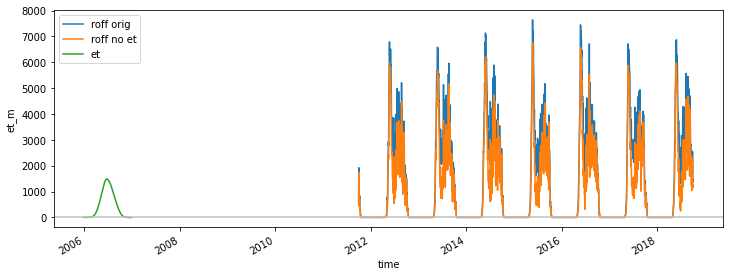

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
rf.roff.where(rf.roff>0).sum(dim = ['lat','lon']).plot(ax=ax,label='roff orig')
rfx.roff.where(rfx.roff>0).sum(dim = ['lat','lon']).plot(ax=ax,label='roff no et')
climatena.et_m.sum(dim = ['lat','lon']).plot(ax=ax,label='et')
plt.axhline(0,color='silver')
plt.legend()

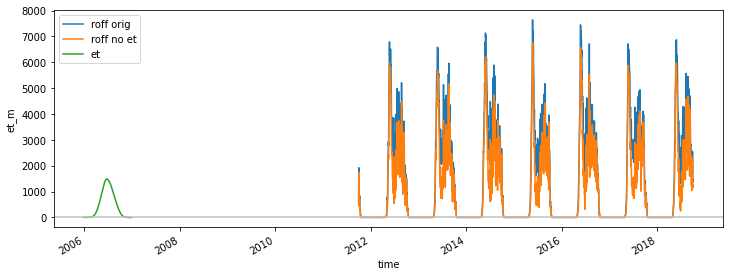

In [14]:
# there is a notable omount of ET that we are not taking into account in april-may because of snow cover
# this is showing results when we do not count snow-covered et pixels
fig, ax = plt.subplots(figsize=(12,4))
rf.roff.where(rf.roff>0).sum(dim = ['lat','lon']).plot(ax=ax,label='roff orig')
rfx.roff.where(rfx.roff>0).sum(dim = ['lat','lon']).plot(ax=ax,label='roff no et')
climatena.et_m.sum(dim = ['lat','lon']).plot(ax=ax,label='et')
plt.axhline(0,color='silver')
plt.legend()

In [15]:
nbsum = rf.rofx.sum(dim='time')
gdatsum = rfx.roff.sum(dim='time')
etnbsum = rf.etx.sum(dim='time')
etgdatsum = et.etx.sum(dim='time')
roffsum = rf.roff.sum(dim='time')

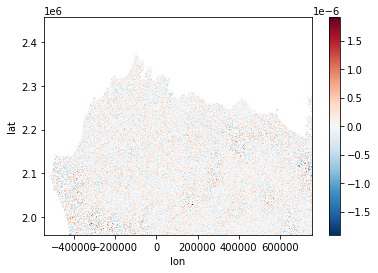

In [16]:
(roffsum.where(nbsum>-9999) - (gdatsum.where(nbsum>-9999)+etgdatsum.where(nbsum>-9999))).plot()

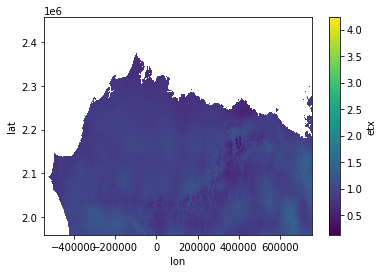

In [17]:
etgdatsum.where(etgdatsum>-9999).plot()

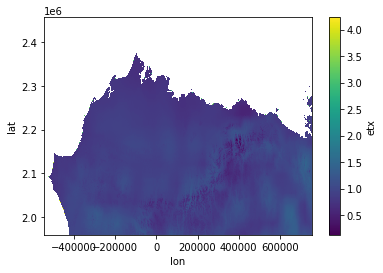

In [18]:
etnbsum.where(etnbsum>-9999).plot()

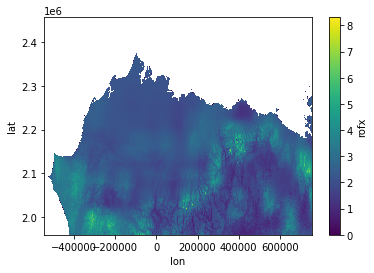

In [19]:
nbsum.where(nbsum>-9999).plot()

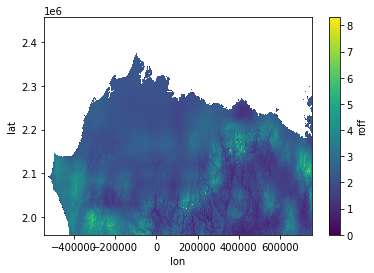

In [20]:
gdatsum.where(gdatsum>-9999).plot()

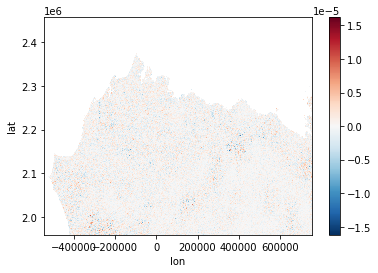

In [21]:
testrof = nbsum.where(nbsum>-9999)-gdatsum.where(nbsum>-9999)
testrof.plot()

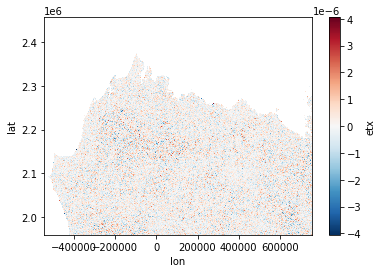

In [22]:
testet = etnbsum.where(etnbsum>-9999)-etgdatsum.where(etnbsum>-9999)
testet.plot()